In [1]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn
import numpy as np
import pickle
import time
import os
import scipy.interpolate as spi

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
problem = {
    'num_vars': 5,
    'names': ["alpha", "prob_health_decrease", "prob_health_increase", "gamma", "w_delta_scale"],
    'bounds': [[0,1], [0,1], [0,1], [0.4,0.8], [0,1]]
}

In [4]:
result_suffix = "3"

### Sen's Welfare Function

In [3]:
def gini(data):
    if len(data) == 0:
        return 0
    data = np.asarray(data)
    data = np.sort(data)
    n = len(data)
    index = np.arange(1, n + 1)  # 1-based index
    gini = (2 * np.sum(index * data)) / (n * np.sum(data)) - (n + 1) / n
    return gini

def sen_welfare(data):
    return np.mean(data) * (1-gini(data))

In [6]:
result_dir = "results_" + result_suffix
sen_results = []

for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])
    sen_results.append(
        (res["params"], sen_welfare(util[:,-1]))
    )

with open(f"sen_welfare_{result_suffix}.pickle", "wb") as f:
    pickle.dump(sen_results, f)

  0%|          | 0/512 [00:00<?, ?it/s]

In [7]:
with open(f"sen_welfare_{result_suffix}.pickle", "rb") as f:
    sen_results = pickle.load(f)

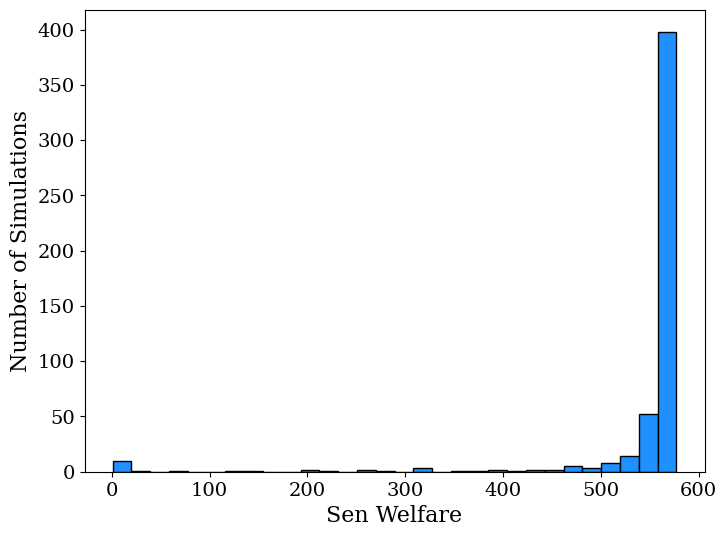

In [15]:
plt.hist(
    [t[1] for t in sen_results],
    bins=30,
    color="dodgerblue",
    edgecolor="k"
)
plt.xlabel("Sen Welfare")
plt.ylabel("Number of Simulations")
plt.show()

In [9]:
X = []
Y = []
for t in sen_results:
    X.append((t[0]["alpha"], t[0]["P_H_decrease"], t[0]["P_H_increase"], t[0]["gamma"], t[0]["w_delta_scale"]))
    Y.append(t[1])
X = np.array(X)
Y = np.array(Y)

pawn.analyze(problem, X, Y, S=10, print_to_console=False)

/Users/charlesdupont/Documents/code/wealth-health/.venv/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


{'minimum': array([0.1082261 , 0.073606  , 0.08969056, 0.05587469, 0.10914522]),
 'mean': array([0.21806096, 0.13761018, 0.35033259, 0.11523172, 0.25812064]),
 'median': array([0.18185126, 0.13978248, 0.35883885, 0.11847044, 0.24454274]),
 'maximum': array([0.52516085, 0.18887868, 0.62725361, 0.18267463, 0.70027043]),
 'CV': array([0.53586797, 0.24497566, 0.40635293, 0.3237406 , 0.62304047]),
 'names': ['alpha',
  'prob_health_decrease',
  'prob_health_increase',
  'gamma',
  'w_delta_scale']}

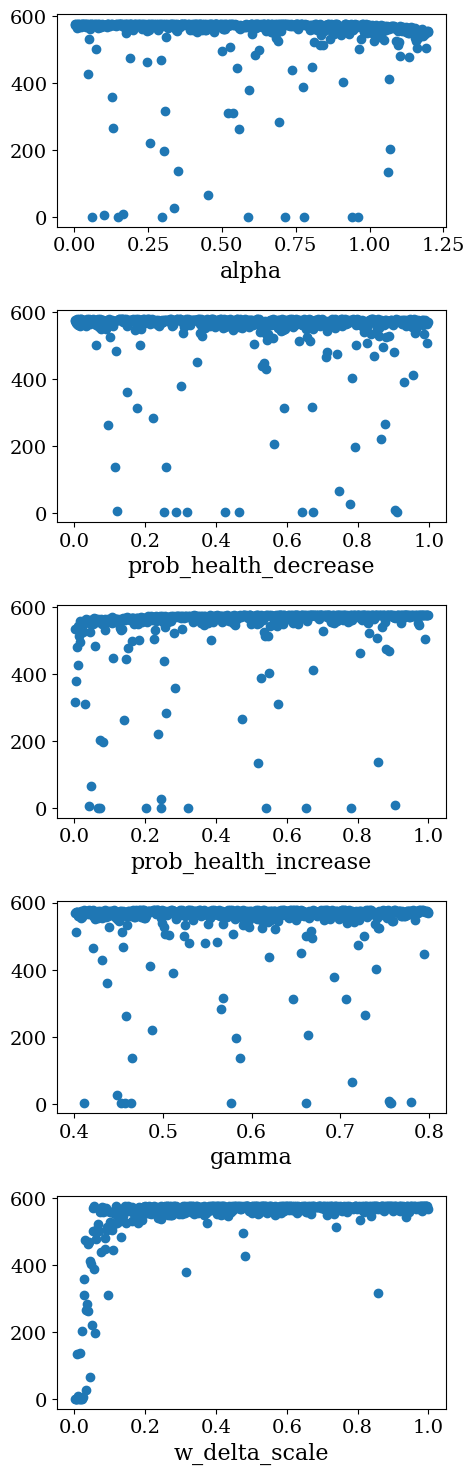

In [16]:
num_vars = problem["num_vars"]
fig, axs = plt.subplots(num_vars, 1, figsize=(5,15))
for idx in range(num_vars):
    axs[idx].scatter(
        X[:,idx],
        Y,
    )
    axs[idx].set_xlabel(problem["names"][idx])
fig.tight_layout()
plt.show()

### MFPT

In [11]:
def compute_MFPT(n_steps, n_simulations, start_pos, target_pos, step_size, interpolate):
    rand_nums = np.random.uniform(0, 1, size=(n_steps, n_simulations))
    rand_angle = np.random.uniform(0, 2 * np.pi, size=(n_steps, n_simulations))

    target_x = np.full(n_simulations, target_pos[0])
    target_y = np.full(n_simulations, target_pos[1])

    X = np.zeros((n_simulations, n_steps+1))
    X[:,0] = start_pos[0]
    Y = np.zeros((n_simulations, n_steps+1))
    Y[:,0] = start_pos[1]

    still_moving = np.ones((n_simulations,))
    FPT = np.full_like(np.zeros(n_simulations,), n_steps)
    
    current_potential = interpolate(X[:,0], Y[:,0], grid=False)

    for step in range(n_steps):
        dx = np.cos(rand_angle[step]) * step_size
        dy = np.sin(rand_angle[step]) * step_size
        new_potential = interpolate(X[:,step] + dx, Y[:,step] + dy, grid=False)

        # check whether to accept or reject moves
        accept = np.logical_or(new_potential < current_potential, rand_nums[step] < np.exp(current_potential - new_potential))
        current_potential = np.where(accept, new_potential, current_potential)

        # update position
        X[:,step+1] = X[:,step] + accept * dx * still_moving
        Y[:,step+1] = Y[:,step] + accept * dy * still_moving

        reached_target = (X[:,step+1] - target_x)**2 + (Y[:,step+1] - target_y)**2 < step_size**2
        FPT = np.where(np.logical_and(still_moving, reached_target), step, FPT)
        still_moving = np.where(reached_target, 0, still_moving)

        if not np.any(still_moving):
            break

    return FPT.mean()


def random_walk(n_steps, start_pos, step_size, interpolate, alpha, exp_factor=1):
    rand_nums = np.random.uniform(0, 1, size=(n_steps,))
    rand_angle = np.random.uniform(0, 2 * np.pi, size=(n_steps,))

    X = np.zeros((n_steps+1,))
    X[0] = start_pos[0]
    Y = np.zeros((n_steps+1,))
    Y[0] = start_pos[1]
    util = np.zeros((n_steps+1,))
    util[0] = utility(X[0], Y[0], alpha)
    current_potential = interpolate(X[0], Y[0])

    for step in range(n_steps):
        dx = np.cos(rand_angle[step]) * step_size
        dy = np.sin(rand_angle[step]) * step_size

        new_x = max(1, min(X[step] + dx, 200))
        new_y = max(1, min(Y[step] + dy, 200))        
        new_potential = interpolate(new_x, new_y, grid=False)

        # check whether to accept or reject moves
        accept = False
        if (new_potential < current_potential) or rand_nums[step] < exp_factor * np.exp(current_potential - new_potential):
            accept = True        
            current_potential = new_potential
            X[step+1] = new_x
            Y[step+1] = new_y
        else:
            X[step+1] = X[step]
            Y[step+1] = Y[step]
        
        util[step+1] = utility(X[step+1], Y[step+1], alpha)

    return util, X, Y

In [12]:
result_dir = "results_" + result_suffix

interpolation_functions = []
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    interp_func = get_interpolation_function(
        res["wealth"][:,-1],
        res["health"][:,-1]
    )
    interpolation_functions.append(
        (res["params"], interp_func)
    )

with open(f"interpolation_functions_{result_suffix}.pickle", "wb") as f:
    pickle.dump(interpolation_functions, f)

  0%|          | 0/512 [00:00<?, ?it/s]

In [23]:
MINIMA = []
for param_set, func in tqdm(interpolation_functions):
    MINIMA.append(
        (param_set, get_minima(func, count_threshold=2, num_points=15, N=param_set["N"], step_size=10))
    )
with open(f"minima_{result_suffix}.pickle", "wb") as f:
    pickle.dump(MINIMA, f)

  0%|          | 0/512 [00:00<?, ?it/s]

In [24]:
with open(f"minima_{result_suffix}.pickle", "rb") as f:
    MINIMA = pickle.load(f)

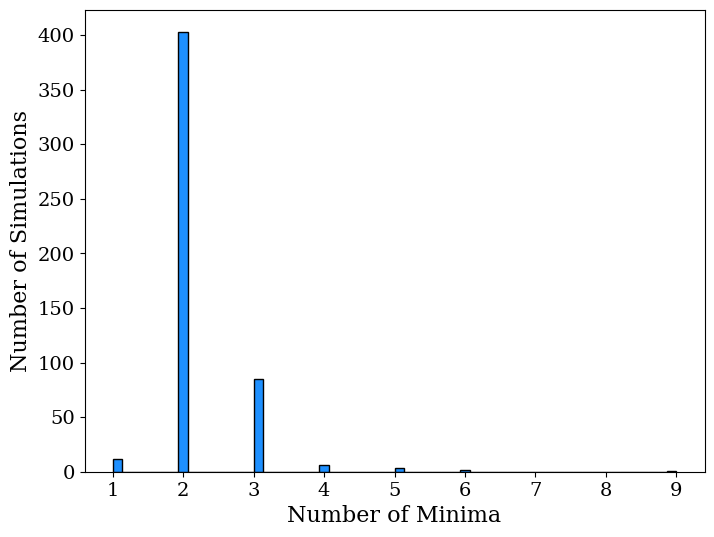

In [25]:
plt.hist(
    [len(m[1]) for m in MINIMA],
    bins=60,
    color="dodgerblue",
    edgecolor="k"
)
plt.xlabel("Number of Minima")
plt.ylabel("Number of Simulations")
plt.show()

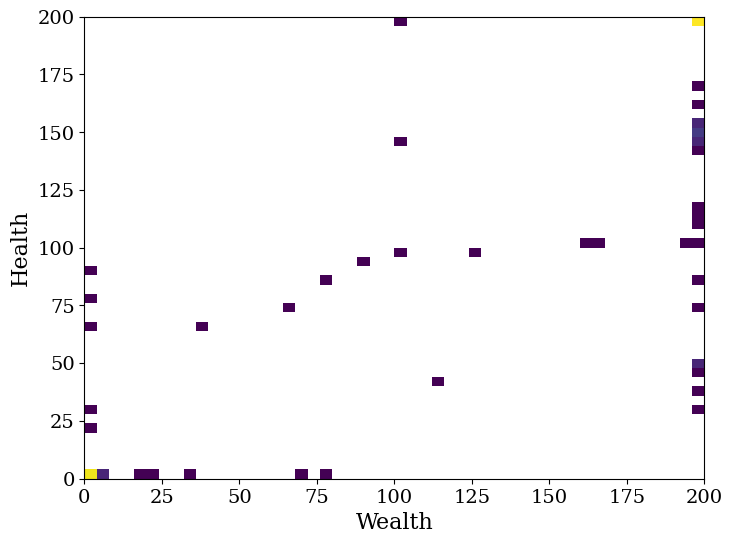

In [26]:
minima_locations = []
for m in MINIMA:
    for point in m[1]:
        minima_locations.append(point[0])

plt.hist2d(
    [x[0] for x in minima_locations],
    [x[1] for x in minima_locations],
    bins=50,
    norm="log"
)

plt.xlabel("Wealth")
plt.ylabel("Health")
plt.show()

0it [00:00, ?it/s]

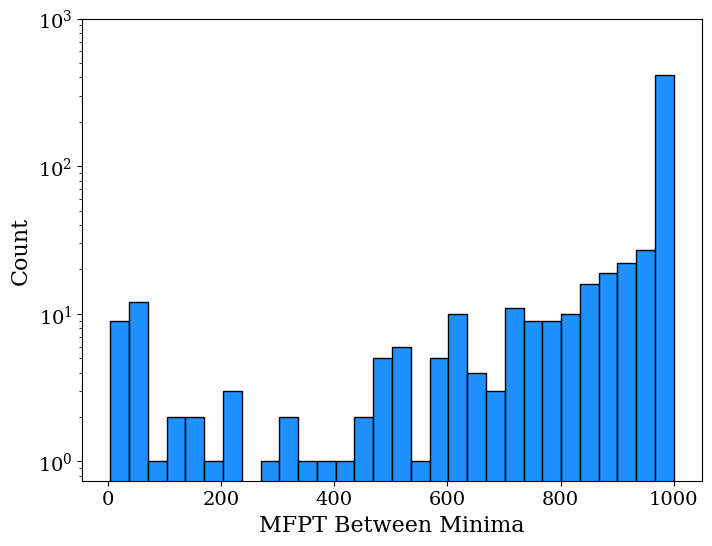

In [242]:
MFPT_results = []
for simulation_idx, item in tqdm(enumerate(MINIMA)):
    params, minima_list = item
    assert len(minima_list) > 0
    result = {}
    for i in range(len(minima_list)):
        w_i, h_i = minima_list[i][0]
        for j in range(i+1, len(minima_list)):
            w_j, h_j = minima_list[j][0]
            func = interpolation_functions[simulation_idx][1]
            delta_utility = utility(w_j, h_j, params["alpha"]) - utility(w_i, h_i, params["alpha"])
            mfpt = compute_MFPT(
                n_steps=1000,
                n_simulations=100,
                start_pos=(w_i, h_i),
                target_pos=(w_j, h_j),
                step_size=5,
                interpolate=func
            )
            result[((w_i,h_i),(w_j,h_j))] = {
                "delta_util" : delta_utility,
                "mfpt" : mfpt
            }
    MFPT_results.append((params, result))


all_times = []
for item in MFPT_results:
    mfpt = item[1]
    for key,val in mfpt.items():
        all_times.append(val["mfpt"])

all_times = [x for x in all_times if x!=np.inf]
plt.hist(
    all_times,
    bins=30,
    color="dodgerblue",
    edgecolor="k"
)
plt.yscale("log")
plt.xlabel("MFPT Between Minima")
plt.ylabel("Count")
plt.yticks([1,10,100,1000])
plt.show()

In [17]:
# with open("MFPT_results.pickle", "wb") as f:
#     pickle.dump(MFPT_results, f)

In [27]:
all_utils = []
for simulation_idx, item in tqdm(enumerate(MINIMA)):
    params, minima_list = item
    util_diffs = []
    for i in range(len(minima_list)):
        if minima_list[i][1] <= 2:
            continue
        w_i, h_i = minima_list[i][0]
        util, x, y = random_walk(100, (w_i,h_i), 1, interpolation_functions[simulation_idx][1], params["alpha"], exp_factor=0.5)
        util_diffs.append(util.max() - util[0])
    all_utils.append(
        (
            params,
            np.mean(util_diffs)
        )
    )

0it [00:00, ?it/s]

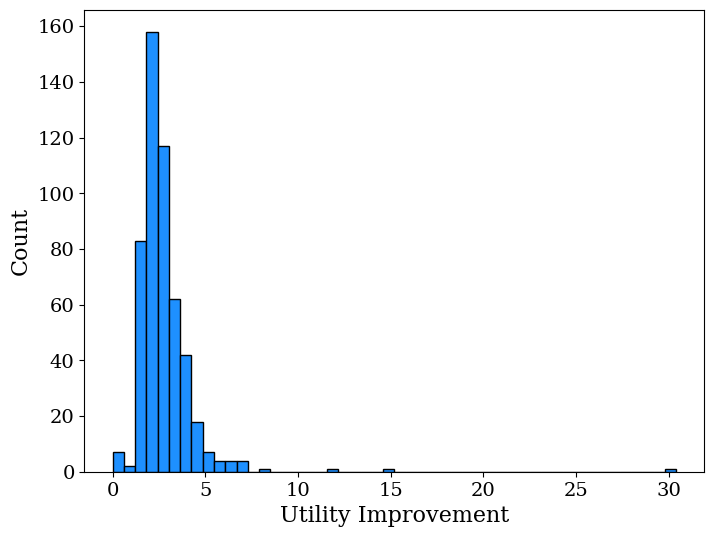

In [28]:
plt.hist(
    [x[1] for x in all_utils],
    color="dodgerblue",
    edgecolor="k",
    bins=50
)
plt.xlabel("Utility Improvement")
plt.ylabel("Count")
plt.show()

In [29]:
X = []
Y = []
for t in all_utils:
    X.append((t[0]["alpha"], t[0]["P_H_decrease"], t[0]["P_H_increase"], t[0]["gamma"], t[0]["w_delta_scale"]))
    Y.append(t[1])
X = np.array(X)
Y = np.array(Y)

pawn.analyze(problem, X, Y, S=10, print_to_console=False)

/Users/charlesdupont/Documents/code/wealth-health/.venv/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


{'minimum': array([0.06403186, 0.0692019 , 0.06935509, 0.05934495, 0.07130821]),
 'mean': array([0.14607018, 0.15028045, 0.13137225, 0.10815953, 0.14432327]),
 'median': array([0.15098128, 0.16224783, 0.13139553, 0.10837929, 0.11540671]),
 'maximum': array([0.23111979, 0.20580576, 0.18179087, 0.17401961, 0.32286659]),
 'CV': array([0.34221985, 0.32620921, 0.23018422, 0.34015436, 0.52936819]),
 'names': ['alpha',
  'prob_health_decrease',
  'prob_health_increase',
  'gamma',
  'w_delta_scale']}

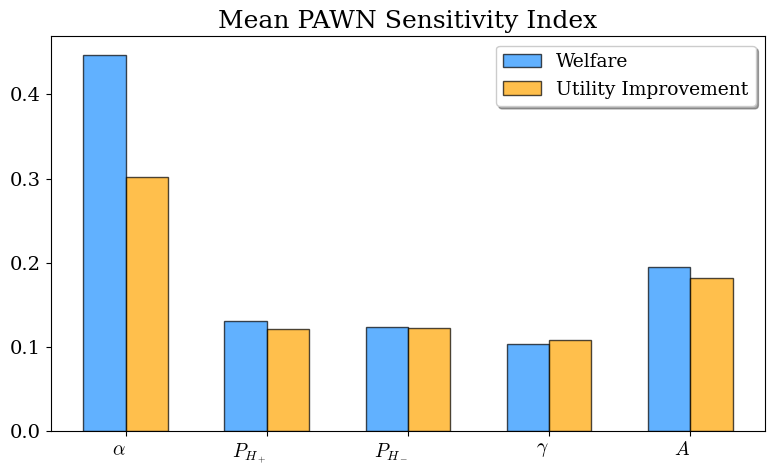

In [30]:
# Categories on x-axis
categories = [r'$\alpha$', r'$P_{H_+}$', r'$P_{H_-}$', r'$\gamma$', r'$A$']

# Data for the bars
bar1_values = [0.44650942, 0.13076246, 0.12437135, 0.10305017, 0.19526684]
bar2_values = [0.30162289, 0.12170178, 0.12276083, 0.10814951, 0.18214673]

# X locations for the groups
x = np.arange(len(categories))

# Width of bars
width = 0.3  

# Create bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, bar1_values, width, label='Welfare', color='dodgerblue', alpha=0.7, edgecolor="k")
ax.bar(x + width/2, bar2_values, width, label='Utility Improvement', color='orange', alpha=0.7, edgecolor="k")

# Labels and title
ax.set_title("Mean PAWN Sensitivity Index")
ax.set_xticks(x)
ax.set_xticklabels(categories, ha="right")
ax.legend(shadow=True)

# Show plot
plt.tight_layout()
plt.show()

### Investigate final state space outcome as function of initial state

In [34]:
init_w = []
init_h = []

result_dir = "results_" + result_suffix
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    condition = (wealth[:,-1] >= 195) & (health[:,-1] >= 196)
    init_w.append(wealth[condition,0])
    init_h.append(health[condition,0])

init_w = np.concatenate(init_w)
init_h = np.concatenate(init_h)

  0%|          | 0/512 [00:00<?, ?it/s]

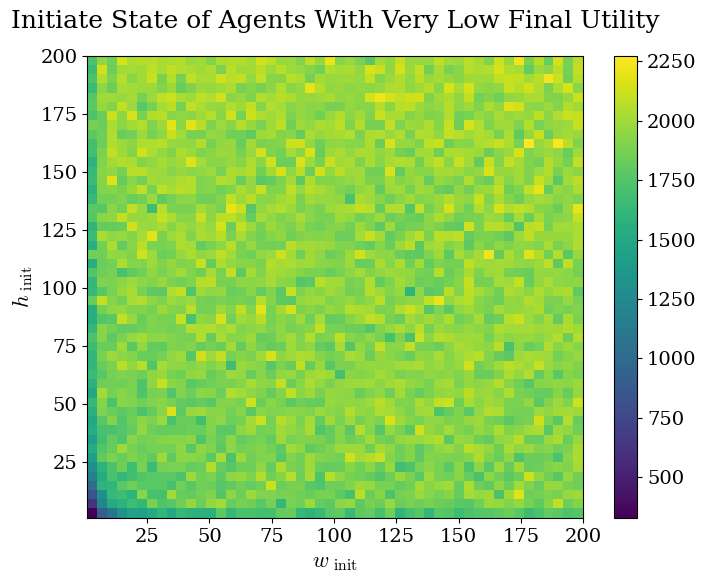

In [36]:
fig, ax = plt.subplots()
h = ax.hist2d(init_w, init_h, bins=50)
fig.colorbar(h[3], ax=ax)

plt.xlabel(r"$w_{\text{ init}}$")
plt.ylabel(r"$h_{\text{ init}}$")
plt.title("Initiate State of Agents With Very Low Final Utility", pad=20)
plt.show()